$\textbf{We first get the data from the files _ISP1Requirements.csv and BalancePrices.csv and perform some preprocessing}$

$\textbf{Notes Uplift Account }$

* Uplift 1 : Λογφαριασμός Προσαυξήσεων Απωλειών ΕΣΜΗΕ
$$UPLIFT_1 = LOSSES \cdot \frac{MQ_{p,t}}{\sum MQ_{p,t}}$$
* LOSSES είναι το συνολικό κόστος των Απωλειών ΕΣΜΗΕ σε $ όπως προκύπτει απο την εκαθάριση κάθε αγοράς.

* Uplift 2 : Λογαριασμός Προσαυξ΄λησεων Ισχύος Εξισορρόπησης
$$UPLIFT_2 = BALCAP \cdot \frac{MQ_{p,t}}{\sum MQ_{p,t}}$$
* BALCAP είναι η συνολικ΄γ αποζημείωση όλων των Οντοτήτων Υπηρεσιών Εξισορρόπησης για την παραχθείσα Ισχύ για ανοδική και καθοδική ΕΔΣ, αυτόματη ΕΑΣ και χειροκίνητη ΕΑΣ για την Περιοδο εκκαθάρισης Αποκλίσεων t

* Uplift 3 : Λογαριασμός Προσαυξήσεων Οικονομικήες Ουδευτερότητας

$$UPLIFT_3 = NEUTR_t \cdot \frac{MQ_{p,t}}{\sum_p MQ_{p,t}}$$

* Το ποσό για την διασφάλιση της οικονομικής ουδετερότητας του Διαχειριστή του ΕΣΜΗΕ NEUTR για κάθε Περιόδο Εκκαθάρισης Αποκλίσεων t επιβαρύνει και επιμερίζεςται στα Συμβαλλόμενα Μέρη με Ευθύνη Εξισορρόπησης ανάλογα με την μετρούμενη απορρόφηση των πελατών τους  


* Μεθοδολογία Υπολογισμού Απωλειών 

Η μεθοδολογία πρόβλεψης των απωλειών βασίζεται στην πρόβλεψη των εγχύσεψν και απομαστευσεων ισχύος στοτς ζυγούς του Συστήματος.




In [258]:
from urllib.parse import urljoin
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
from csv import reader

In [259]:
def make_dt_index(df, timestamp_col, dt_offset=None):
    df.index = pd.to_datetime(
        df.loc[:, timestamp_col], format='%Y-%m-%dT%H:%M:%S.%f'
    )

    if dt_offset:
        df.index = df.index + dt_offset

    df.drop(timestamp_col, axis=1, inplace=True)

    df.sort_index(inplace=True)

    return df


def check_duplicate_index(df, verbose=True):
    """ checks for duplicates in the index of a dataframe """
    dupes = df[df.index.duplicated()]
    num = dupes.shape[0]
    print('{} index duplicates'.format(num))

    if verbose == True:
        print('duplicates are:')
        print(dupes.head(3))

    return df[df.index.duplicated(keep=False)]


def drop_duplicate_index(df):
    return df[~df.index.duplicated(keep='first')]


def check_duplicate_rows(df, verbose=True):
    duplicated_bools = df.duplicated()
    num = np.sum(duplicated_bools)
    print('{} row duplicates'.format(num))

    if verbose:
        df[duplicated_bools].head(3)

    return df[df.duplicated(keep=False)]


def check_nans(df, verbose=True):
    """ checks for NANs in a dataframe """
    nans = df[df.isnull().any(axis=1)]
    num = nans.shape[0]

    print('{} nan rows'.format(num))
    if verbose:
        print('nan values are:')
        print(nans.head())

    return nans


def check_index_length(df, freq, verbose=True):
    """ compare a DatetimeIndex with the expected length """
    ideal = pd.DatetimeIndex(start=df.index[0],
                             end=df.index[-1],
                             freq=freq)

    ideal_len = ideal.shape[0]
    actual_len = df.shape[0]
    num_missing = ideal_len - actual_len
    print('ideal index len {} actual {} missing {}'.format(
        ideal_len, actual_len, num_missing))

    if ideal.shape[0] != df.shape[0]:
        missing = set(df.index).symmetric_difference(set(ideal))

        if verbose:
            print('missing are:')
            print(missing)

        return missing, ideal

    else:
        return None, df.index


def make_df_fill_dt_index(df, freq, method='ffill'):

    missing, ideal = check_index_length(df, freq)

    ideal_idx_df = pd.DataFrame(index=ideal)

    df = pd.concat([ideal_idx_df, df], axis=1)

    return df.fillna(method=method)


def check_dataframe(df, freq, verbose=False):
    """ wraps together all the checks """
    duplicate_index = check_duplicate_index(df, verbose)

    duplicate_rows = check_duplicate_rows(df, verbose)

    nans = check_nans(df, verbose)

    missing_index, ideal_index = check_index_length(df, freq, verbose)

    return {
        'duplicate_index': duplicate_index,
        'duplicate_rows': duplicate_rows,
        'nans': nans,
        'missing_index': missing_index,
        'ideal_index': ideal_index
    }
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [260]:
requirements_data = pd.read_csv('_ISP1Requirements.csv')
balancing_prices_data  = pd.read_csv('BalancePrices.csv')

In [261]:
columns_data = requirements_data.columns

In [262]:
requirements_data[columns_data[0]] = pd.to_datetime(requirements_data[columns_data[0]])
requirements_data.set_index(columns_data[0], drop=True, inplace=True)
requirements_data.index.name = None

In [263]:
requirements_data.head()

RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1750.0  5742.0             50.0      894.0
2021-08-15 00:30:00  1790.0  5575.0             50.0      904.0
2021-08-15 01:00:00  1850.0  5456.0             50.0      924.0
2021-08-15 01:30:00  1910.0  5347.0             50.0      924.0
2021-08-15 02:00:00  1950.0  5251.0             50.0      954.0

In [264]:
balancing_prices_data['Unnamed: 0'] = pd.to_datetime(balancing_prices_data['Unnamed: 0'])
balancing_prices_data.set_index('Unnamed: 0', drop=True, inplace=True)
balancing_prices_data.index.name = None

In [265]:
balancing_prices_data = balancing_prices_data.drop(balancing_prices_data.columns[[9, 10]],axis=1)

In [266]:
requirements_data
requirements_data['Date'] = pd.to_datetime(requirements_data.index)  

In [267]:
balancing_prices_data['Date'] = pd.to_datetime(balancing_prices_data.index)

In [268]:
#greater than the start date and smaller than the end date
start_date = '2021-08-15 00:00:00'
end_date   = '2022-04-17 23:45:00'
mask = (requirements_data['Date'] >= start_date) & (requirements_data['Date'] <= end_date)

In [269]:
requirements_data_new = requirements_data.loc[mask]

In [270]:
requirements_data_hourly =  requirements_data_new.resample('H', on='Date', closed='right').mean().reset_index()

In [271]:
mask_2 = (balancing_prices_data['Date'] >= start_date) & (balancing_prices_data['Date'] <= end_date)

In [272]:
balancing_prices_data_new = balancing_prices_data.loc[mask_2]

In [273]:
balancing_prices_hourly = balancing_prices_data_new.resample('H', on='Date', closed='right').mean().reset_index()

In [274]:
balancing_prices_hourly['Date'] = pd.to_datetime(balancing_prices_hourly['Date'])
balancing_prices_hourly.set_index('Date', drop=True, inplace=True)
balancing_prices_hourly.index.name = None

In [275]:
requirements_data_hourly['Date'] = pd.to_datetime(requirements_data_hourly['Date'])
requirements_data_hourly.set_index('Date', drop=True, inplace=True)
requirements_data_hourly.index.name = None

In [276]:
balancing_prices_hourly =  balancing_prices_hourly.iloc[1: , :]

In [277]:
requirements_data_hourly =requirements_data_hourly.iloc[1: , :]

In [278]:
requirements_data_hourly.head()

RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [279]:
balancing_prices_hourly.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  
2021-08-15 00:00:00                  0.662670                  5.481142  
2021-08-15 01:00:00                  1.098814                  2.754350  
2021-08-15 02:00:00                  1.201918                  3.213499  
2021-08-15 03:00:00                  1.117085                  3.079745  
2021-08-15 04:00:00                  1.156230                  2.383576

$\textbf{Now we are going to add the Load Forecast from the entsoe api and some other exogenous features}$

In [280]:
from entsoe import EntsoePandasClient
import pandas as pd
api_key="7d2255de-e63f-4766-805a-0c0a1f6e7fa3"
client = EntsoePandasClient(api_key=api_key)
country_code = 'GR'

In [281]:
start = pd.Timestamp('20210814', tz='UTC')
end = pd.Timestamp('20220418', tz='UTC')
load_forecast = client.query_load_forecast(country_code, start=start, end = end)
load_forecast.head()

Forecasted Load
2021-08-14 03:00:00+03:00           5740.0
2021-08-14 04:00:00+03:00           5560.0
2021-08-14 05:00:00+03:00           5489.0
2021-08-14 06:00:00+03:00           5422.0
2021-08-14 07:00:00+03:00           5570.0

In [282]:
load_forecast = load_forecast.iloc[21:5925,:]

In [283]:
load_forecast = load_forecast.set_index(balancing_prices_hourly.index)

In [284]:
combined_dataframes = pd.concat([balancing_prices_hourly, requirements_data_hourly], axis=1, join="inner")

In [285]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0  
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0  
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0  
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0  
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [286]:
check_nans(combined_dataframes)
features = combined_dataframes.columns

0 nan rows
nan values are:
Empty DataFrame
Columns: [Total Activated Balancing Energy UP (MWh), Total Activated Balancing Energy Down (MWh), Total Activated Balancing Energy (MWh), Imbalance Price  (€/MWh), mFRR Price UP (€/MWh), mFRR Price Down (€/MWh), Uplift Account 1 (€/MWh), Uplift Account 2 (€/MWh), Uplift Account 3 (€/MWh), RES, Load, Mandatory Hydro, Total FRR]
Index: []


In [287]:
Imbalance_price = combined_dataframes[features[3]]

combined_dataframes_new = combined_dataframes.drop(features[3],axis=1)

In [288]:
combined_dataframes_new["Imbalance_price"] = Imbalance_price

In [289]:
combined_dataframes_new.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     mFRR Price UP (€/MWh)  mFRR Price Down (€/MWh)  \
2021-08-15 00:00:00               141.3900                  40.7625   
2021-08-15 01:00:00                86.9275                  26.3325   
2021-08-15 02:00:00                27.8250                   0.0100   
2021-08-15 03:00:00                28.5925                   0.0100   
2021-08-15 04:00:00                28.5925                  17.8275   

                     Uplift Account 1 (€/MWh)  Uplift Account 2 (€/MWh)  \
2021-08-15 00:00:00                  2.738548                  0.662670   
2021-08-15 01:00:00                  2.375837                  1.098814   
2021-08-15 02:00:00                  2.143069                  1.201918   
2021-08-15 03:00:00                  2.043232                  1.117085   
2021-08-15 04:00:00                  2.227400                  1.156230   

                     Uplift Account 3 (€/MWh)     RES    Load  \
2021-08-15 00:00:00                  5.481142  1820.0  5515.5   
2021-08-15 01:00:00                  2.754350  1930.0  5299.0   
2021-08-15 02:00:00                  3.213499  2000.0  5127.5   
2021-08-15 03:00:00                  3.079745  2035.0  5038.0   
2021-08-15 04:00:00                  2.383576  2055.0  4951.5   

                     Mandatory Hydro  Total FRR  Imbalance_price  
2021-08-15 00:00:00             50.0      914.0        38.036567  
2021-08-15 01:00:00             50.0      939.0        23.803718  
2021-08-15 02:00:00             50.0      949.0        25.178707  
2021-08-15 03:00:00             63.0      939.0         0.010000  
2021-08-15 04:00:00             76.0     1079.0        17.827500

In [290]:
def df_info(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Imbalance_price" in df:
        corrSP = df.corr(method='pearson').Imbalance_price
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    
    return df_resume

pd.set_option('max_rows', None)


In [291]:
###### Statistics for 
df_info(combined_dataframes_new)

type  \
Total Activated Balancing Energy UP (MWh)    float64   
Total Activated Balancing Energy Down (MWh)  float64   
Total Activated Balancing Energy (MWh)       float64   
mFRR Price UP (€/MWh)                        float64   
mFRR Price Down (€/MWh)                      float64   
Uplift Account 1 (€/MWh)                     float64   
Uplift Account 2 (€/MWh)                     float64   
Uplift Account 3 (€/MWh)                     float64   
RES                                          float64   
Load                                         float64   
Mandatory Hydro                              float64   
Total FRR                                    float64   
Imbalance_price                              float64   

                                                                                        Sample  \
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Imbalance_price                              [38.0365670475, 23.803718415, 25.17870695, 0.0...   

                                             % of NaN  Corr_with_y  \
Total Activated Balancing Energy UP (MWh)           0     0.592970   
Total Activated Balancing Energy Down (MWh)         0    -0.372177   
Total Activated Balancing Energy (MWh)              0     0.671568   
mFRR Price UP (€/MWh)                               0     0.768857   
mFRR Price Down (€/MWh)                             0     0.395989   
Uplift Account 1 (€/MWh)                            0     0.690137   
Uplift Account 2 (€/MWh)                            0     0.263268   
Uplift Account 3 (€/MWh)                            0     0.290910   
RES                                                 0    -0.081067   
Load                                                0     0.220631   
Mandatory Hydro                                     0     0.150217   
Total FRR                                           0     0.080078   
Imbalance_price                                     0     1.000000   

                                             Duplicates  Amount Uniques  \
Total Activated Balancing Energy UP (MWh)             0            5904   
Total Activated Balancing Energy Down (MWh)           0            5904   
Total Activated Balancing Energy (MWh)                0            5904   
mFRR Price UP (€/MWh)                                 0            5034   
mFRR Price Down (€/MWh)                               0            4711   
Uplift Account 1 (€/MWh)                              0            5904   
Uplift Account 2 (€/MWh)                              0            5904   
Uplift Account 3 (€/MWh)                              0            5904   
RES                                                   0             857   
Load                                                  0            4219   
Mandatory Hydro                                       0            1573   
Total FRR

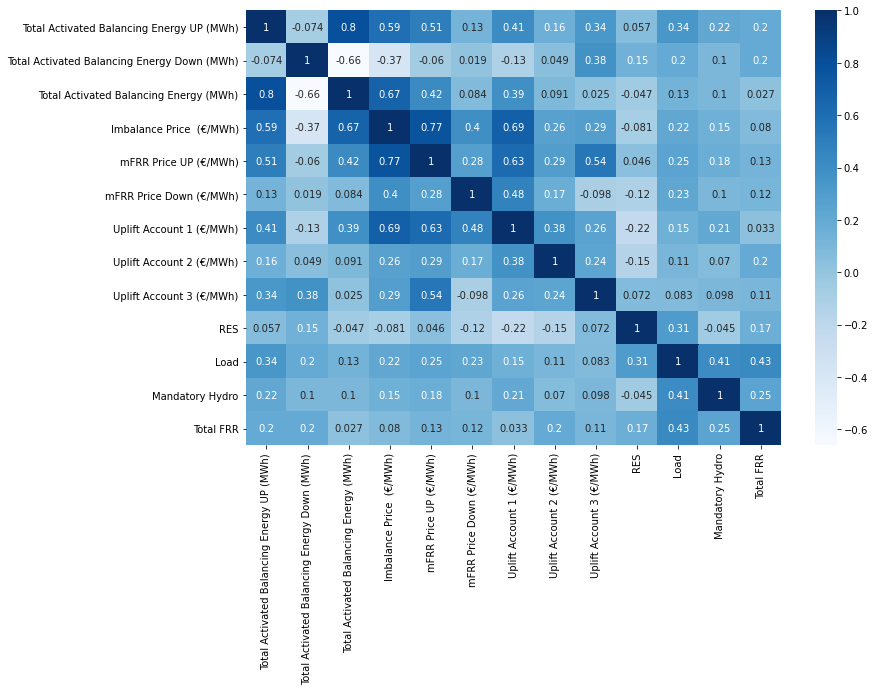

In [292]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(combined_dataframes.corr(), cmap='Blues', annot=True)
plt.show()

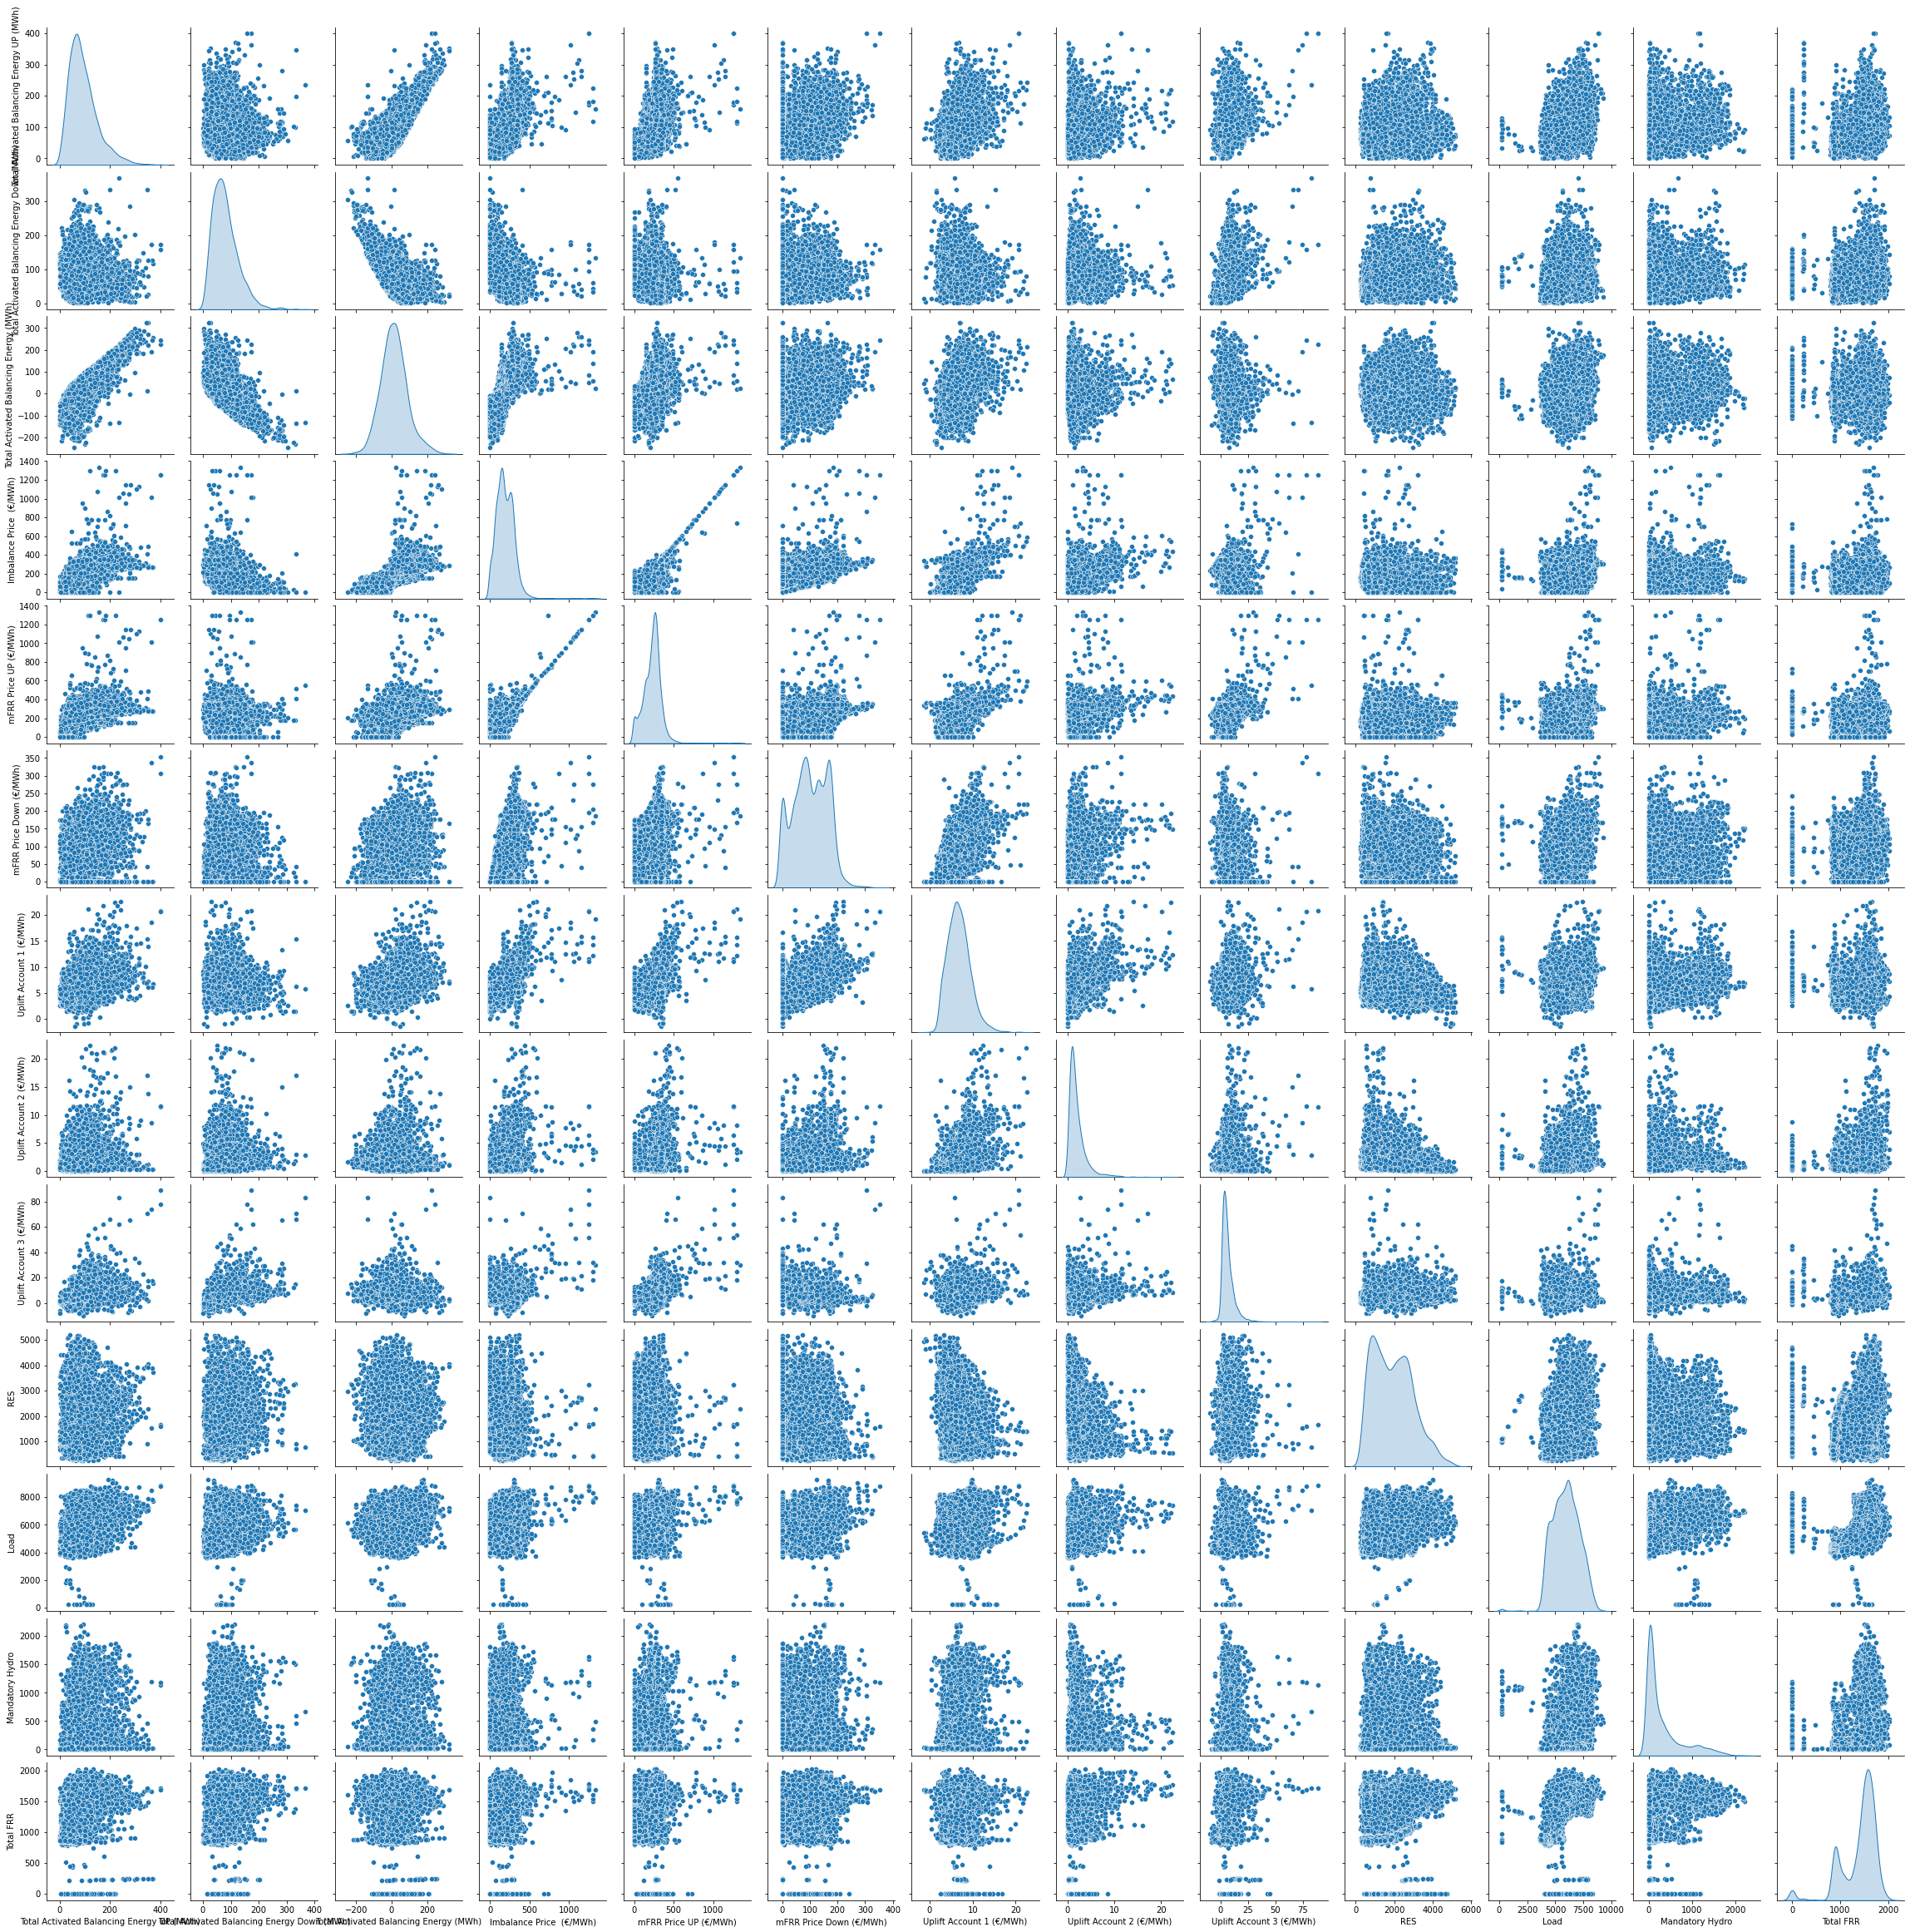

In [293]:
sns.pairplot(data=combined_dataframes, diag_kind='kde')

$\textbf{Now we are going to add the Day Ahead Prices}$

In [294]:
day_ahead_prices =client.query_day_ahead_prices(country_code, start= start, end = end)

In [295]:
len(day_ahead_prices)

5929

In [296]:
day_ahead_prices = day_ahead_prices.iloc[21:5925 ,]

In [297]:
len(day_ahead_prices)

5904

In [298]:
combined_dataframes["Day_ahead_price"] = day_ahead_prices.values

In [299]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  
2021-08-15 00:00:00            95.16  
2021-08-15 01:00:00           103.16  
2021-08-15 02:00:00            91.91  
2021-08-15 03:00:00            77.00  
2021-08-15 04:00:00            83.80

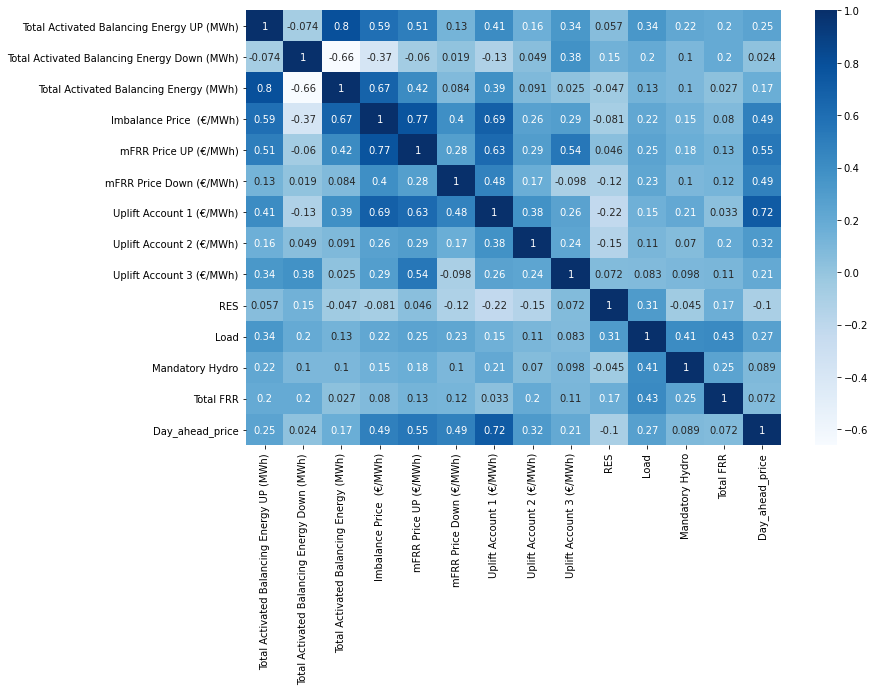

In [300]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(combined_dataframes.corr(), cmap='Blues', annot=True)
plt.show()

In [301]:
def df_info_2(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Day_ahead_price" in df:
        corrSP = df.corr(method='pearson').Day_ahead_price
        
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    df_resume = df_resume.sort_values(by = "Corr_with_y")
    
    return df_resume

pd.set_option('max_rows', None)


In [302]:
df_info_2(combined_dataframes)

type  \
RES                                          float64   
Total Activated Balancing Energy Down (MWh)  float64   
Total FRR                                    float64   
Mandatory Hydro                              float64   
Total Activated Balancing Energy (MWh)       float64   
Uplift Account 3 (€/MWh)                     float64   
Total Activated Balancing Energy UP (MWh)    float64   
Load                                         float64   
Uplift Account 2 (€/MWh)                     float64   
mFRR Price Down (€/MWh)                      float64   
Imbalance Price  (€/MWh)                     float64   
mFRR Price UP (€/MWh)                        float64   
Uplift Account 1 (€/MWh)                     float64   
Day_ahead_price                              float64   

                                                                                        Sample  \
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Imbalance Price  (€/MWh)                     [38.0365670475, 23.803718415, 25.17870695, 0.0...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Day_ahead_price                                             [95.16, 103.16, 91.91, 77.0, 83.8]   

                                             % of NaN  Corr_with_y  \
RES                                                 0    -0.102659   
Total Activated Balancing Energy Down (MWh)         0     0.023675   
Total FRR                                           0     0.072386   
Mandatory Hydro                                     0     0.089390   
Total Activated Balancing Energy (MWh)              0     0.171823   
Uplift Account 3 (€/MWh)                            0     0.205866   
Total Activated Balancing Energy UP (MWh)           0     0.247444   
Load                                                0     0.270865   
Uplift Account 2 (€/MWh)                            0     0.316798   
mFRR Price Down (€/MWh)                             0     0.485212   
Imbalance Price  (€/MWh)                            0     0.493490   
mFRR Price UP (€/MWh)                               0     0.545677   
Uplift Account 1 (€/MWh)                            0     0.722581   
Day_ahead_price                                     0     1.000000   

                                             Duplicates  Amount Uniques  \
RES                                                   0             857   
Total Activated Balancing Energy Down (MWh)           0            5904   
Total FRR                                             0             475   
Mandatory Hydro                                       0            1573   
Total Activated Balancing Energy (MWh)                0            5904   
Uplift Account 3 (€/MWh)                              0            5904   
Total Activated Balancing Energy UP (MWh)             0            5904   
Load                                                  0            4219   
Uplift Acc

In [303]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  
2021-08-15 00:00:00            95.16  
2021-08-15 01:00:00           103.16  
2021-08-15 02:00:00            91.91  
2021-08-15 03:00:00            77.00  
2021-08-15 04:00:00            83.80

$\textbf{Uplift Account seems to have positive correlation with both Day ahead Prices and Imbalance Prices}$

$$UPLIFT_1 = LOSSES_t \cdot \frac{MQ_{p,t}}{\sum_p MQ_{p,t}}$$

* LOSSES : το συνολικό κόστος των Απωλειών ΕΣΜΗΕ, σε €, όπως προκύπτει από την εκκαθάριση της Αγοράς Επόμενης Ημέρας, την εκκαθάριση της Ενδοημερήσιας Αγοράς και την Εκκαθάριση Αποκλίσεων για τις Απώλειες αυτές, για την Περίοδο Εκκαθάρισης Αποκλίσεων t,
* MQ :η απορρόφηση (υπολογιζόμενη στο Όριο Συστήματος ΜεταφοράςΔικτύου Διανομής) σε MWh που αντιστοιχεί στους καταναλωτές του Διασυνδεδεμένου Συστήματος ανά Συμβαλλόμενο Μέρος με Ευθύνη Εξισορρόπησης p για την Περίοδο Εκκαθάρισης Αποκλίσεων t.

* 

$\textbf{We add now a new column with the difference between the Day Ahead price and the Balancing Price}$

$$\psi = \lambda^D - \lambda^B$$

In [304]:
def df_info_3(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Day_ahead_Balancing_diff" in df:
        corrSP = df.corr(method='pearson').Day_ahead_Balancing_diff
        
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    df_resume = df_resume.sort_values(by = "Corr_with_y")
    
    return df_resume

pd.set_option('max_rows', None)


In [305]:
combined_dataframes.head()
combined_dataframes["Day_ahead_Balancing_diff"] = combined_dataframes.iloc[:,13].values - combined_dataframes.iloc[:,3].values

In [306]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  
2021-08-15 00:00:00            95.16                 57.123433  
2021-08-15 01:00:00           103.16                 79.356282  
2021-08-15 02:00:00            91.91                 66.731293  
2021-08-15 03:00:00            77.00                 76.990000  
2021-08-15 04:00:00            83.80                 65.972500

In [307]:
df_info_3(combined_dataframes)

type  \
Imbalance Price  (€/MWh)                     float64   
Total Activated Balancing Energy (MWh)       float64   
Total Activated Balancing Energy UP (MWh)    float64   
mFRR Price UP (€/MWh)                        float64   
Uplift Account 1 (€/MWh)                     float64   
Uplift Account 3 (€/MWh)                     float64   
mFRR Price Down (€/MWh)                      float64   
Mandatory Hydro                              float64   
Uplift Account 2 (€/MWh)                     float64   
Load                                         float64   
Total FRR                                    float64   
RES                                          float64   
Day_ahead_price                              float64   
Total Activated Balancing Energy Down (MWh)  float64   
Day_ahead_Balancing_diff                     float64   

                                                                                        Sample  \
Imbalance Price  (€/MWh)                     [38.0365670475, 23.803718415, 25.17870695, 0.0...   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Day_ahead_price                                             [95.16, 103.16, 91.91, 77.0, 83.8]   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Day_ahead_Balancing_diff                     [57.123432952499996, 79.356281585, 66.73129305...   

                                             % of NaN  Corr_with_y  \
Imbalance Price  (€/MWh)                            0    -0.792475   
Total Activated Balancing Energy (MWh)              0    -0.644111   
Total Activated Balancing Energy UP (MWh)           0    -0.501597   
mFRR Price UP (€/MWh)                               0    -0.492715   
Uplift Account 1 (€/MWh)                            0    -0.279039   
Uplift Account 3 (€/MWh)                            0    -0.186848   
mFRR Price Down (€/MWh)                             0    -0.110596   
Mandatory Hydro                                     0    -0.108343   
Uplift Account 2 (€/MWh)                            0    -0.077587   
Load                                                0    -0.061253   
Total FRR                                           0    -0.040411   
RES                                                 0     0.020309   
Day_ahead_price                                     0     0.139387   
Total Activated Balancing Energy Down (MWh)         0     0.440336   
Day_ahead_Balancing_diff                            0     1.000000   

                                             Duplicates  Amount Uniques  \
Imbalance Price  (€/MWh)                              0            5761   
Total Activated Balancing Energy (MWh)                0            5904   
Total Activated Balancing Energy UP (MWh)             0            5904   
mFRR Price UP (€/MWh)                                 0            5034   
Uplift Account 1 (€/MWh)                              0            5904   
Uplift Acco

In [308]:
features  = combined_dataframes.columns

In [309]:
features[3]

'Imbalance Price  (€/MWh)'

$\textbf{We are going to check for some outliers in the data}$

Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


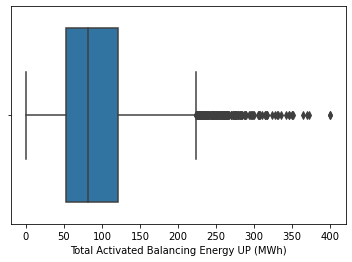

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


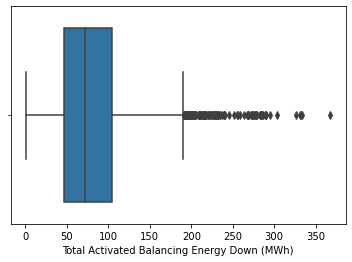

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


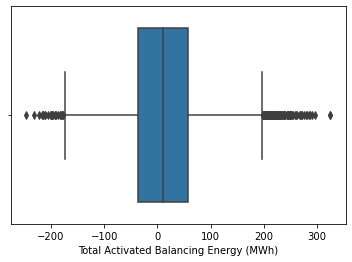

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


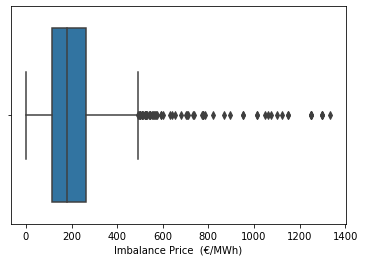

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


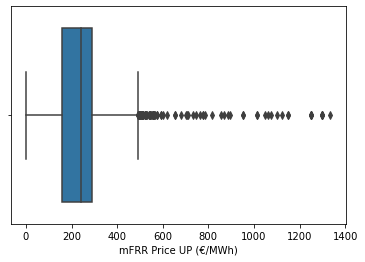

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


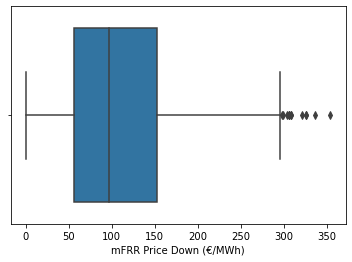

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


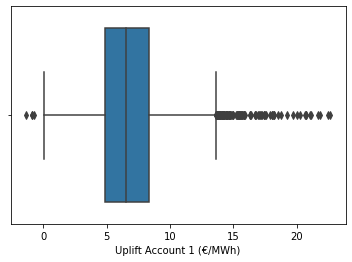

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


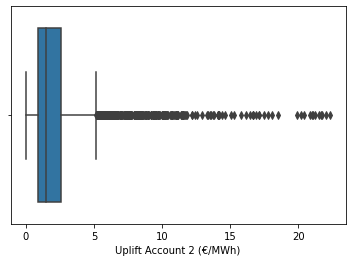

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


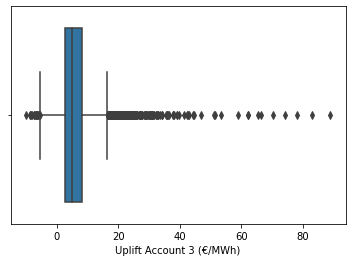

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


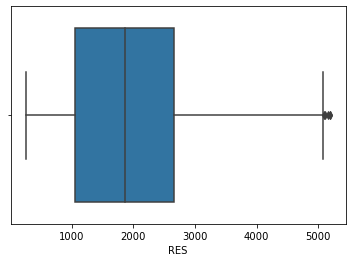

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


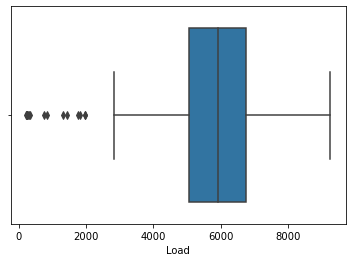

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


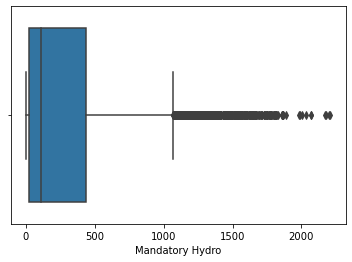

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


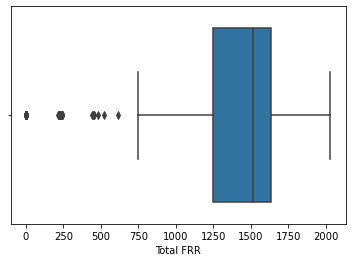

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


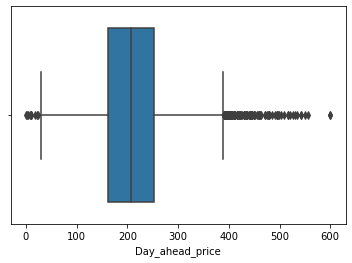

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


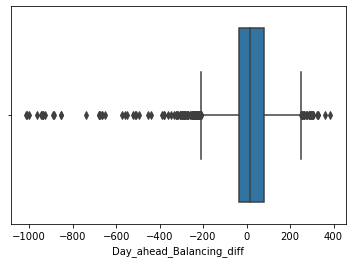

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 125 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns


In [310]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

$\textbf{All the prices of the Balancing Market prices that are >= 600 will be replaced with 600}$

In [311]:
combined_dataframes[features[3]].loc[combined_dataframes[features[3]]>= 600 ] = 600

In [312]:
combined_dataframes[features[4]].loc[combined_dataframes[features[4]]>=800] = 800

In [313]:
combined_dataframes[features[11]].loc[combined_dataframes[features[11]]>= 1800] = 1500

Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


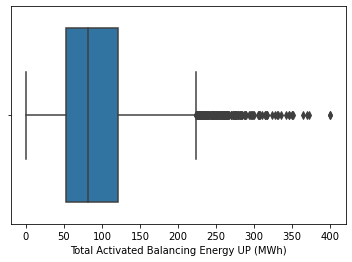

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


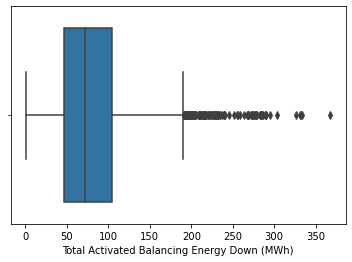

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


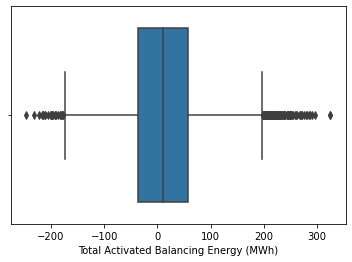

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


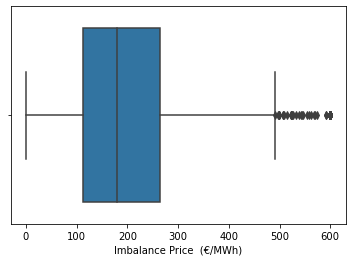

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


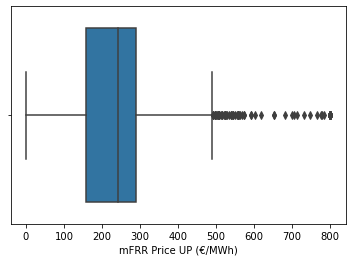

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


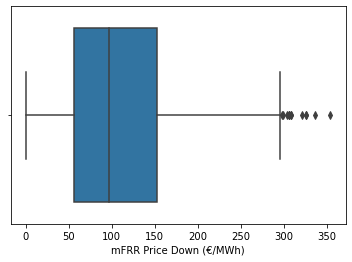

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


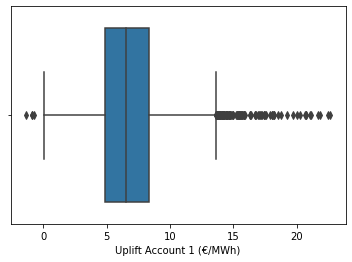

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


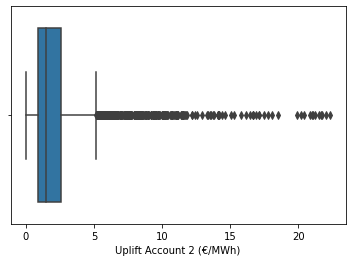

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


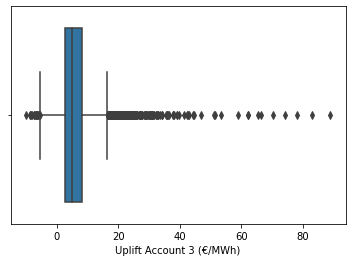

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


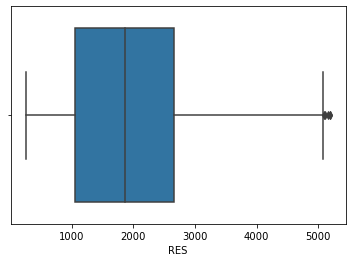

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


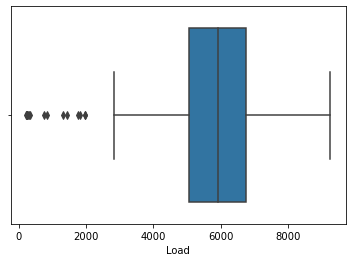

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


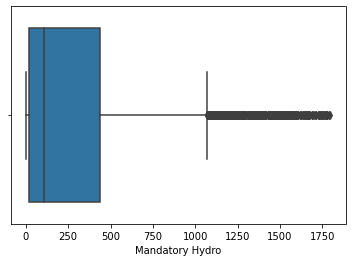

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


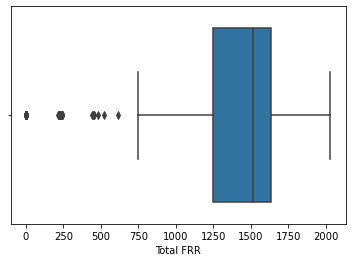

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


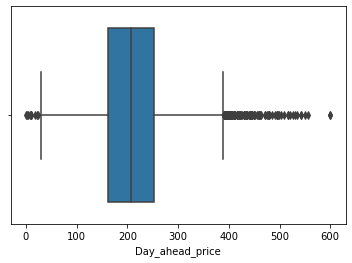

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


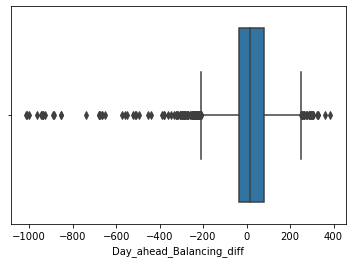

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 125 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns


In [314]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [315]:
column_names = ['Activated_energy_up','Activated_energy_down','Activated_balancing_energy','Imbalance_price','mFRR_up','mFRR_down','Uplift_account_1','Uplift_account_2','Uplift_account_3','RES','Load','Mandatory_hydro','Total_FRR','Forecasted_load','Day_ahead_price','Day_ahead_Balancing_diff']

In [316]:
combined_dataframes["Diff_direction"] = [1 if int(x) >= 0 else 0 for x in combined_dataframes[features[14]]]

In [317]:
combined_dataframes.head(50)

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   
2021-08-15 05:00:00                                    88.882660   
2021-08-15 06:00:00                                   116.949175   
2021-08-15 07:00:00                                   131.068113   
2021-08-15 08:00:00                       

In [318]:
features  = combined_dataframes.columns

In [319]:
combined_dataframes["Date"] = combined_dataframes.index
combined_dataframes.to_csv('All_data.csv',index=True, encoding='utf-8')

$\textbf{We are going to choose the right model in order to predict the Day Ahead Balancing Difference}$

Regression Model 

Classification Model

$\textbf{1) We are first going to create a classification Model}$

In [320]:
y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

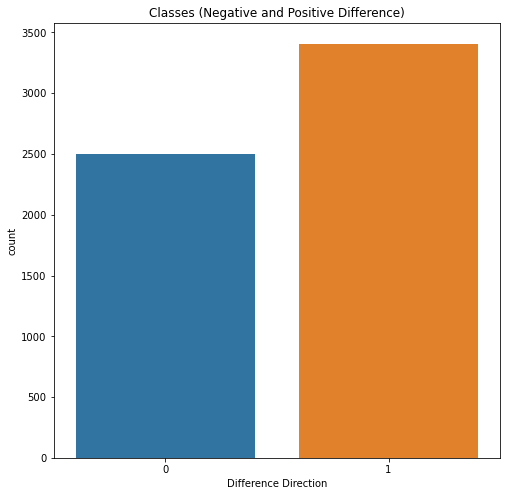

In [321]:
plt.figure(figsize=(8, 8))
sns.countplot(data=combined_dataframes, x='Diff_direction')
plt.title('Classes (Negative and Positive Difference)')
plt.xlabel("Difference Direction")
plt.show()

In [322]:
combined_dataframes.head()
#combined_dataframes = combined_dataframes.drop("Date",axis=1)


Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  \
2021-08-15 00:00:00            95.16                 57.123433   
2021-08-15 01:00:00           103.16                 79.356282   
2021-08-15 02:00:00            91.91                 66.731293   
2021-08-15 03:00:00            77.00                 76.990000   
2021-08-15 04:00:00            83.80                 65.972500   

                     Diff_direction                Date  
2021-08-15 00:00:00               1 2021-08-15 00:00:00  
2021-08-15 01:00:00               1 2021-08-15 01:00:00  
2021-08-15 02:00:00               1 2021-08-15 02:00:00  
2021-08-15 03:00:00               1 2021-08-15 03:00:00  
2021-08-15 04:00:00               1 2021-08-15 04:00:00

In [149]:
x = combined_dataframes.drop([features[3],features[13],features[14],features[15],"Date"], axis=1)
x.head(100)

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   
2021-08-17 02:00:00                                  77.870902   
2021-08-17 03:00:00                                  73.393180   
2021-08-17 04:00:00                                  67.051213   
2021-08-17 05:00:00                                  74.816285   
2021-08-17 06:00:00                                  81.145027   
2021-08-17 07:00:00                                  71.166612   
2021-08-17 08:00:00                                  36.785637   
2021-08-17 09:00:00                                  31.828213   
2021-08-17 10:00:00                                  32.978278   
2021-08-17 11:00:00                                  43.62552

In [207]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  \
2021-08-15 00:00:00            95.16                 57.123433   
2021-08-15 01:00:00           103.16                 79.356282   
2021-08-15 02:00:00            91.91                 66.731293   
2021-08-15 03:00:00            77.00                 76.990000   
2021-08-15 04:00:00            83.80                 65.972500   

                     Diff_direction                Date  
2021-08-15 00:00:00               1 2021-08-15 00:00:00  
2021-08-15 01:00:00               1 2021-08-15 01:00:00  
2021-08-15 02:00:00               1 2021-08-15 02:00:00  
2021-08-15 03:00:00               1 2021-08-15 03:00:00  
2021-08-15 04:00:00               1 2021-08-15 04:00:00

In [208]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [209]:
X_train.head()
X_test.head()

Total Activated Balancing Energy UP (MWh)  \
2022-02-09 02:00:00                                  11.656385   
2022-01-18 06:00:00                                 115.339923   
2021-08-29 06:00:00                                  80.913408   
2021-10-19 20:00:00                                 222.971747   
2022-02-21 21:00:00                                  73.386910   

                     Total Activated Balancing Energy Down (MWh)  \
2022-02-09 02:00:00                                    67.032545   
2022-01-18 06:00:00                                   166.560178   
2021-08-29 06:00:00                                   102.244848   
2021-10-19 20:00:00                                    62.703467   
2022-02-21 21:00:00                                   124.980463   

                     Total Activated Balancing Energy (MWh)  \
2022-02-09 02:00:00                              -55.376160   
2022-01-18 06:00:00                              -51.220255   
2021-08-29 06:00:00                              -21.331440   
2021-10-19 20:00:00                              160.268280   
2022-02-21 21:00:00                              -51.593552   

                     mFRR Price UP (€/MWh)  mFRR Price Down (€/MWh)  \
2022-02-09 02:00:00                193.000                  99.4800   
2022-01-18 06:00:00                298.610                   3.0625   
2021-08-29 06:00:00                 89.400                  53.0500   
2021-10-19 20:00:00                430.575                 120.0000   
2022-02-21 21:00:00                243.125                  58.4175   

                     Uplift Account 1 (€/MWh)  Uplift Account 2 (€/MWh)  \
2022-02-09 02:00:00                  4.284197                  3.297815   
2022-01-18 06:00:00                  4.767066                  2.453213   
2021-08-29 06:00:00                  2.698639                  0.906631   
2021-10-19 20:00:00                 10.067399                 16.931833   
2022-02-21 21:00:00                  4.337611                  2.426069   

                     Uplift Account 3 (€/MWh)     RES    Load  \
2022-02-09 02:00:00                  1.733895  2245.0  4879.5   
2022-01-18 06:00:00                 20.819783  1915.0  6842.5   
2021-08-29 06:00:00                  2.577105   735.0  5215.0   
2021-10-19 20:00:00                 16.555005  1260.0  5898.5   
2022-02-21 21:00:00                  9.248603  1890.0  5588.0   

                     Mandatory Hydro  Total FRR  
2022-02-09 02:00:00              0.0      986.0  
2022-01-18 06:00:00           1166.5     1631.0  
2021-08-29 06:00:00            359.0     1554.0  
2021-10-19 20:00:00            210.5     1819.0  
2022-02-21 21:00:00             31.0     1726.0

In [210]:
num_columns = X_train.columns

$\textbf{a) Logistic Regression Classification}$

In [405]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

In [212]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []


ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [213]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 83.79%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.818036     0.852388   0.83785     0.835212      0.837571
recall        0.802618     0.864575   0.83785     0.833596      0.837850
f1-score      0.810254     0.858438   0.83785     0.834346      0.837654
support    1910.000000  2518.000000   0.83785  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1533  377]
 [ 341 2177]]

_______________________________________________
ROV CURVE SCORE 
 0.8335964303091044

Test Result:
Accuracy Score: 83.13%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.785110    0.862147  0.831301     0.823628      0.831562
recall       0.791809    0.857303  0.831301     0.824556      0.831301
f1-score     0.788445    

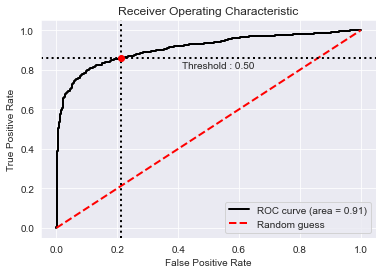

In [214]:
from plot_metric.functions import BinaryClassification
logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

bc.plot_roc_curve()
plt.show()

$\textbf{b) Linear Discriminant Analysis}$

In [215]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
linear_discriminator = LDA(solver='lsqr', shrinkage='auto')
lda_fit_train = linear_discriminator.fit(X_train, y_train)

In [216]:
lda_train_score = linear_discriminator.score(X_train,y_train)
lda_test_score  = linear_discriminator.score(X_test,y_test)

In [217]:
print("LDA Score Train Dataset: ", lda_train_score)
print("LDA Score Test Dataset:" , lda_test_score)

LDA Score Train Dataset:  0.8337850045167118
LDA Score Test Dataset: 0.825880758807588


In [218]:
from sklearn.linear_model import LogisticRegression

print_score(linear_discriminator, X_train, y_train, X_test, y_test, train=True)
print_score(linear_discriminator, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 83.38%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.823594     0.840857  0.833785     0.832226      0.833411
recall        0.782199     0.872915  0.833785     0.827557      0.833785
f1-score      0.802363     0.856586  0.833785     0.829475      0.833197
support    1910.000000  2518.000000  0.833785  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1494  416]
 [ 320 2198]]

_______________________________________________
ROV CURVE SCORE 
 0.8275569823968995

Test Result:
Accuracy Score: 82.59%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.792185    0.846659  0.825881     0.819422      0.825032
recall       0.761092    0.868539  0.825881     0.814816      0.825881
f1-score     0.776327    

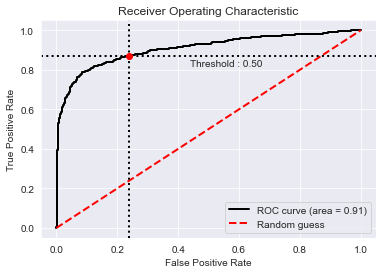

In [219]:
from plot_metric.functions import BinaryClassification
linear_discriminant_prob = linear_discriminator.predict_proba(X=X_test)[:,1]
bc_linear_discriminator = BinaryClassification(y_test, linear_discriminant_prob, labels=["Class 1", "Class 1"])

bc_linear_discriminator.plot_roc_curve()
plt.show()

$\textbf{Neural Network Classification}$

In [220]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

In [221]:
# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())

# ROC Curve
fpr1, tpr1, threshold1 = roc_curve(y_test.values, clf1.predict_proba(X_test)[:,1])
fpr2, tpr2, threshold2 = roc_curve(y_test.values, clf2.predict_proba(X_test)[:,1])
fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

Iteration 1, loss = 1.00419062
Iteration 2, loss = 0.90216141
Iteration 3, loss = 0.80982639
Iteration 4, loss = 0.73088371
Iteration 5, loss = 0.67041434
Iteration 6, loss = 0.62602690
Iteration 7, loss = 0.59304251
Iteration 8, loss = 0.56884475
Iteration 9, loss = 0.54984691
Iteration 10, loss = 0.53485353
Iteration 11, loss = 0.52209229
Iteration 12, loss = 0.51154836
Iteration 13, loss = 0.50259386
Iteration 14, loss = 0.49494231
Iteration 15, loss = 0.48817175
Iteration 16, loss = 0.48200806
Iteration 17, loss = 0.47648097
Iteration 18, loss = 0.47133087
Iteration 19, loss = 0.46646333
Iteration 20, loss = 0.46182968
Iteration 21, loss = 0.45736894
Iteration 22, loss = 0.45312391
Iteration 23, loss = 0.44920126
Iteration 24, loss = 0.44541121
Iteration 25, loss = 0.44180817
Iteration 26, loss = 0.43825580
Iteration 27, loss = 0.43483619
Iteration 28, loss = 0.43151733
Iteration 29, loss = 0.42833898
Iteration 30, loss = 0.42557001
Iteration 31, loss = 0.42290842
Iteration 32, los

0.8502710027100271
0.8441734417344173
0.8538843721770552
0.8468834688346883
0.999096657633243
0.825880758807588


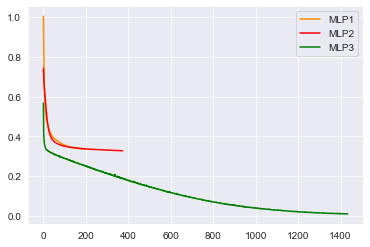

In [222]:
print(clf1.score(X_train, y_train.values.ravel()))
print(clf1.score(X_test, y_test.values.ravel()))
print(clf2.score(X_train, y_train.values.ravel()))
print(clf2.score(X_test, y_test.values.ravel()))
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(clf1.loss_curve_,color="darkorange",label="MLP1")
plt.plot(clf2.loss_curve_,color="red",label="MLP2")
plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

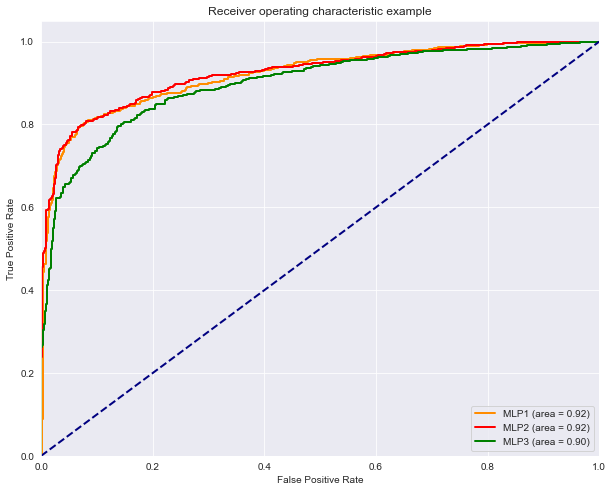

In [223]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    label="MLP1 (area = %0.2f)" % roc_auc1,
)
plt.plot(
    fpr2,
    tpr2,
    color="red",
    lw=lw,
    label="MLP2 (area = %0.2f)" % roc_auc2,
)
plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

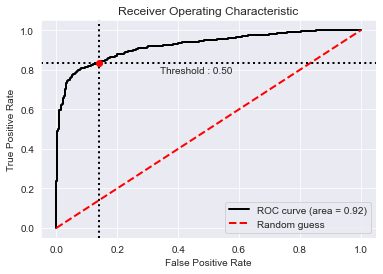

In [224]:
from plot_metric.functions import BinaryClassification
MLP2_classification_prob = clf2.predict_proba(X=X_test)[:,1]
bc_MLP2 = BinaryClassification(y_test, MLP2_classification_prob, labels=["Class 1", "Class 1"])

bc_MLP2.plot_roc_curve()
plt.show()

In [225]:
from sklearn.linear_model import LogisticRegression

print_score(clf2, X_train, y_train, X_test, y_test, train=True)
print_score(clf2, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 85.39%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.803169     0.898934  0.853884     0.851051      0.857626
recall        0.875916     0.837172  0.853884     0.856544      0.853884
f1-score      0.837966     0.866955  0.853884     0.852460      0.854451
support    1910.000000  2518.000000  0.853884  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1673  237]
 [ 410 2108]]

_______________________________________________
ROV CURVE SCORE 
 0.8565442946907916

Test Result:
Accuracy Score: 84.69%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.775229    0.903893  0.846883     0.839561      0.852811
recall       0.865188    0.834831  0.846883     0.850010      0.846883
f1-score     0.817742    

$\textbf{Boosted Decision Trees Classification}$

In [226]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold

In [227]:
GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.844174        0.011978  RandomForestClassifier
1              0.851850        0.013388      AdaBoostClassifier
2              0.851398        0.011994       Gradient Boosting
3              0.787484        0.011435  DecisionTreeClassifier


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


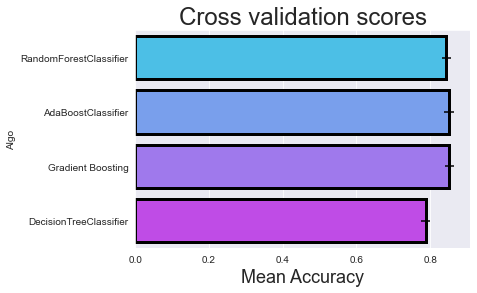

<Figure size 1080x504 with 0 Axes>

In [228]:
kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

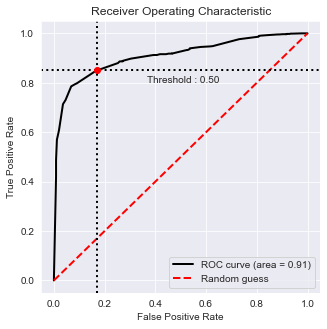

In [229]:
gradient_boost_roc = gradient_fit.predict_proba(X=X_test)
bc = BinaryClassification(y_test, gradient_boost_roc[:,1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [230]:
from sklearn.linear_model import LogisticRegression

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 84.60%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.770246     0.925788   0.84598     0.848017      0.858696
recall        0.916230     0.792693   0.84598     0.854461      0.845980
f1-score      0.836920     0.854086   0.84598     0.845503      0.846682
support    1910.000000  2518.000000   0.84598  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1750  160]
 [ 522 1996]]

_______________________________________________
ROV CURVE SCORE 
 0.8544614898386071

Test Result:
Accuracy Score: 84.21%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.747546    0.930537  0.842141     0.839041      0.857886
recall       0.909556    0.797753  0.842141     0.853655      0.842141
f1-score     0.820631    

$\textbf{Feature Selection}$

* Back propagation to see the importance of each feature based on the ROC AUC Metric Score  

In [312]:
##### Create a list of 11 random colors
from random import randint
color = []
n = 12
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [313]:
x = combined_dataframes.drop([features[3],features[13],features[14],features[15],"Date"], axis=1)
x.head()

y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

In [314]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

1) Logistic Regression 

In [315]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro',
    'Total FRR'    
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Manda

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature nam

['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro', 'Total FRR']


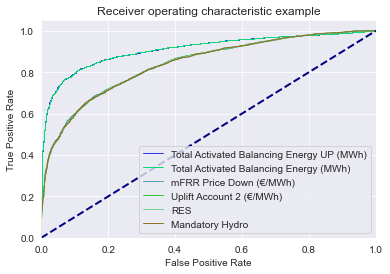

<Figure size 432x288 with 0 Axes>

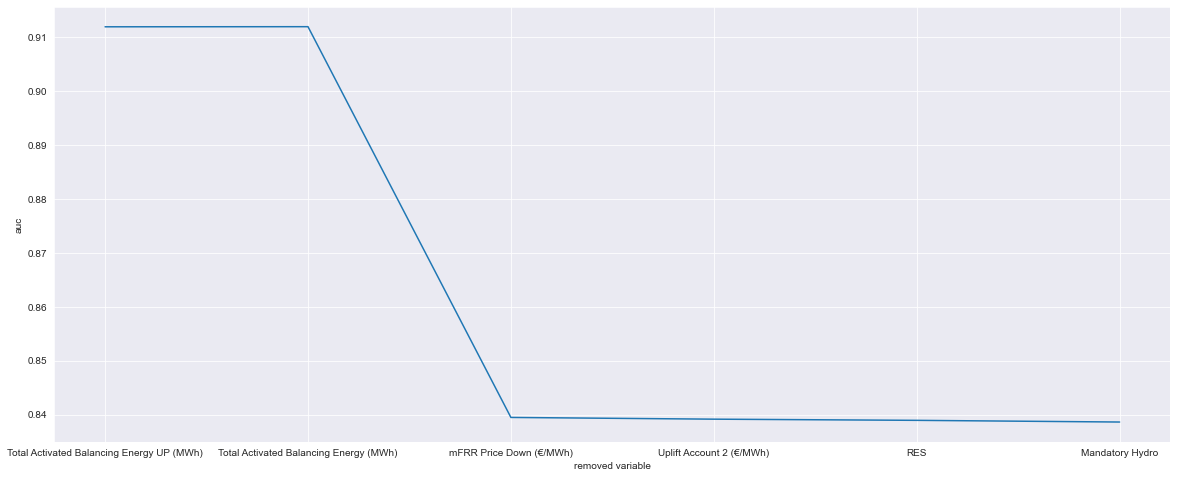

In [316]:
x = []
y = []

plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    lr_clf.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, lr_clf.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)
    
   
    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

2) Neural Network with Logistic Activation Function 

In [317]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro',
    'Total FRR'    
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


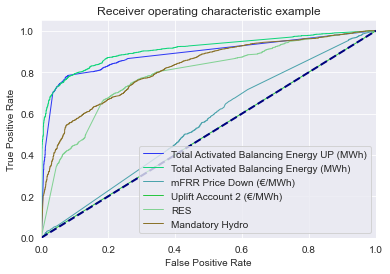

<Figure size 432x288 with 0 Axes>

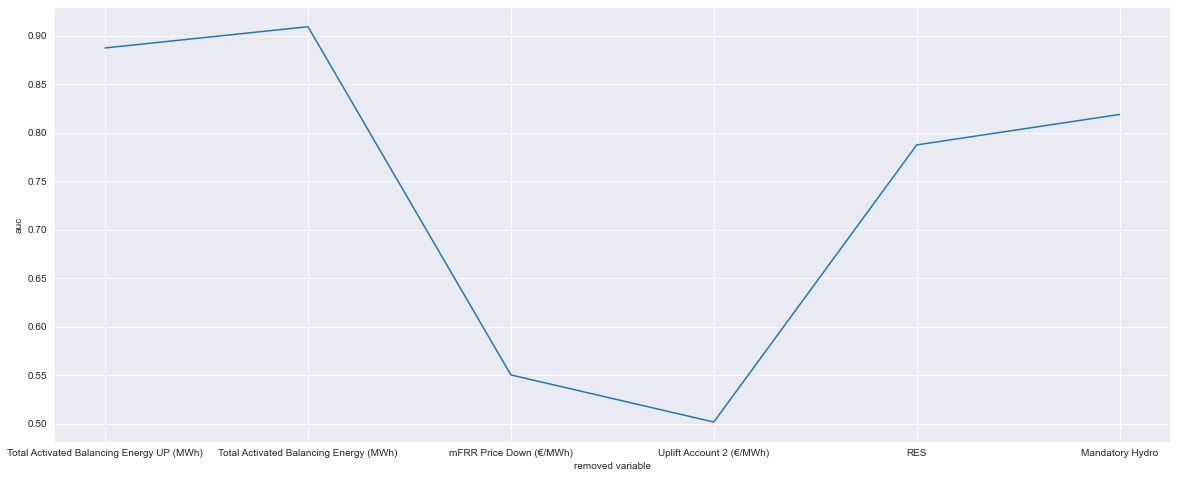

In [318]:
x = []
y = []

plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    clf2.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, clf2.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)
    
   
    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

3) Linear Discriminator 

In [294]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancin

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDis

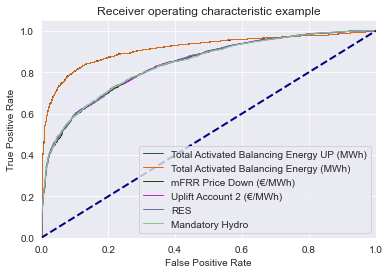

<Figure size 432x288 with 0 Axes>

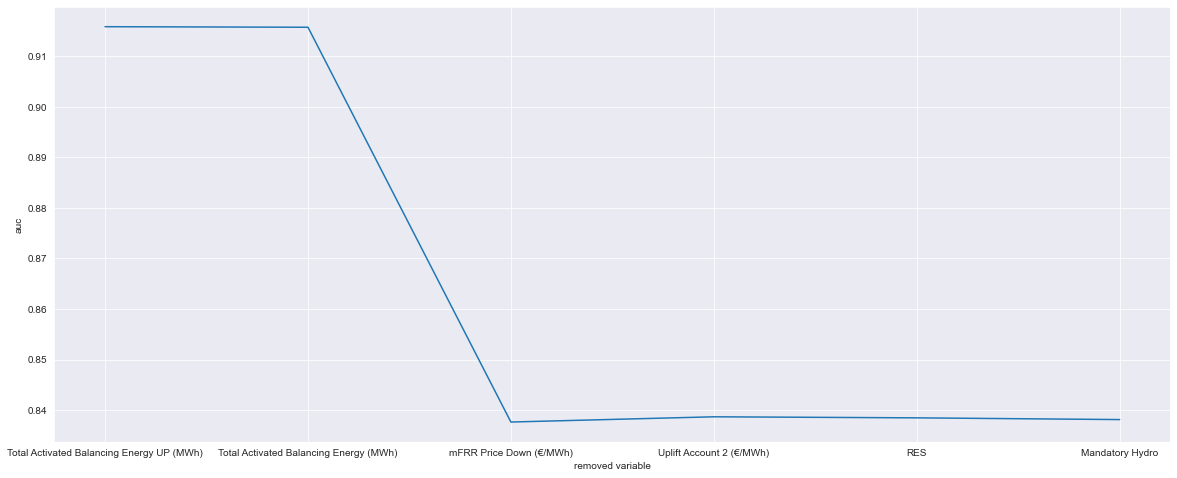

In [295]:


x = []
y = []


plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    lda_fit_train.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, lda_fit_train.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)

    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

4) Gradient Boosting

In [296]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


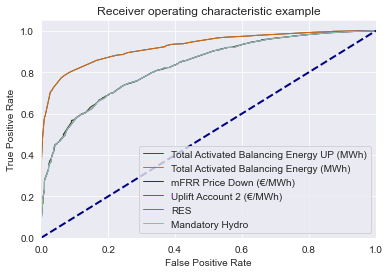

<Figure size 432x288 with 0 Axes>

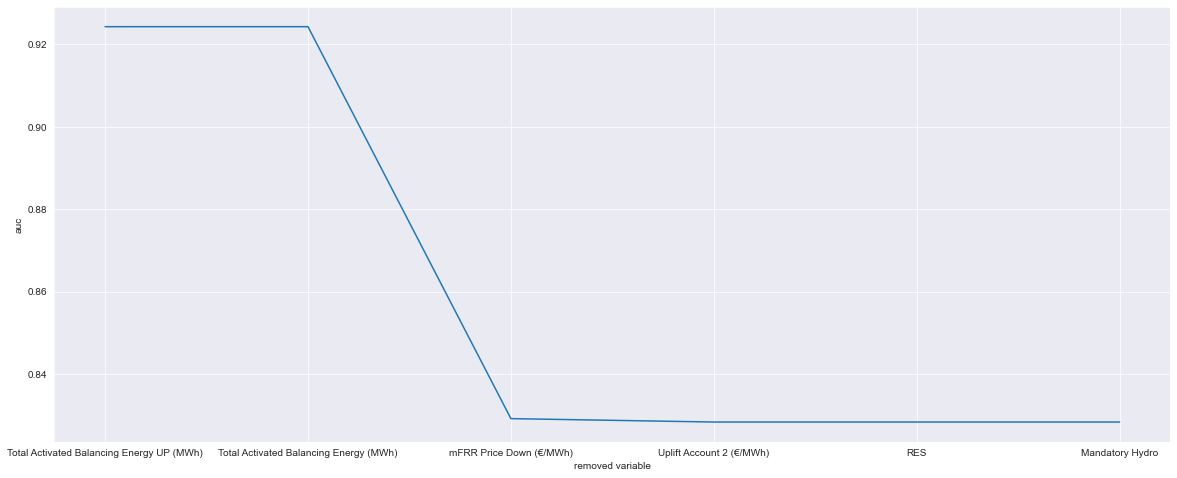

In [297]:


x = []
y = []


plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    GradientBoosting.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, GradientBoosting.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)

    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

**mlxtend - Sequential Feature Selection**

In [191]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

best combination (ROC_AUC: 0.910): (0, 2, 3, 5, 7)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91322768, 0.9072973 , 0.92029933, 0.90626698, 0.90091689]), 'avg_score': 0.9096016379575163, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91375923, 0.90749532, 0.92110186, 0.90684697, 0.90166357]), 'avg_score': 0.9101733906622307, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'L

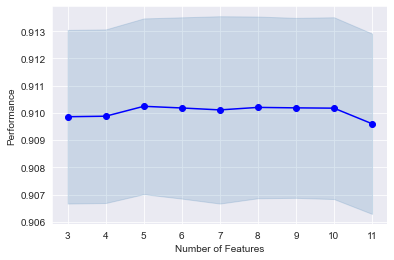

In [192]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]

cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)


sfs1 = SFS(estimator=lda_fit_train, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs1 = sfs1.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [197]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]


best combination (ROC_AUC: 0.915): (0, 1, 5, 7)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.89926417, 0.88853163, 0.89793791, 0.89150086, 0.89459888]), 'avg_score': 0.8943666915580014, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 9, 10), 'cv_scores': array([0.90012142, 0.8936673 , 0.90983777, 0.89286722, 0.89550481]), 'avg_score': 0.8983997068468931, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Accou

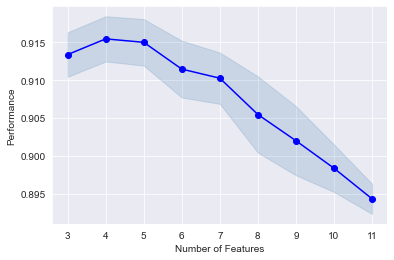

In [198]:
sfs2 = SFS(estimator=clf3, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs2 = sfs2.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_idx_))
print('all subsets:\n', sfs2.subsets_)
plot_sfs(sfs2.get_metric_dict(), kind='std_err');

best combination (ROC_AUC: 0.911): (1, 2, 3, 6, 7, 9, 10)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91885322, 0.90469689, 0.92118003, 0.89765863, 0.90890056]), 'avg_score': 0.9102578663697912, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8, 9, 10), 'cv_scores': array([0.91866561, 0.90448062, 0.92060419, 0.90019542, 0.90890056]), 'avg_score': 0.9105692807761578, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RE

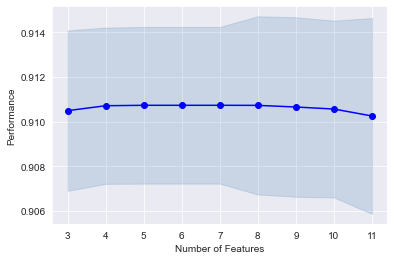

In [196]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]

sfs3 = SFS(estimator=gradient_fit, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs3 = sfs3.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs3.k_score_, sfs3.k_feature_idx_))
print('all subsets:\n', sfs3.subsets_)
plot_sfs(sfs3.get_metric_dict(), kind='std_err');

$\textbf{Classification Analysis with features that have been published before the clearing of the Day Ahead Market}$

In [325]:
Uplift_accounts = [features[6],features[7],features[8]]

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[6],features[7],features[8],features[13],features[14],features[15],"Date"], axis=1)
x.head()



RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [326]:
y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

In [327]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [328]:
X_train.head()

RES    Load  Mandatory Hydro  Total FRR
2021-08-21 05:00:00  1315.0  5042.0            128.0     1404.0
2022-01-15 10:00:00  3800.0  7500.0            980.5     1601.0
2021-10-05 20:00:00  1595.0  5601.5            441.0     1594.0
2021-11-07 04:00:00  2165.0  3845.5              0.0     1164.0
2021-11-11 19:00:00  2480.0  6303.0            335.0     1684.0

In [329]:
X_test.head()

RES    Load  Mandatory Hydro  Total FRR
2021-11-26 05:00:00  1405.0  5424.0             26.0     1264.0
2021-11-23 02:00:00  1345.0  4164.5              0.0      819.0
2022-02-23 08:00:00  2675.0  6918.5            132.0     1631.0
2021-11-04 15:00:00  1140.0  5658.0             17.5     1544.0
2021-08-25 02:00:00   740.0  5136.0             59.5      874.0

$\textbf{Logistic Regression}$

In [330]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

In [331]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []
num_columns = X_train.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [332]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 57.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.520309     0.587829  0.579946     0.554069      0.559147
recall        0.143009     0.902631  0.579946     0.522820      0.579946
f1-score      0.224354     0.711985  0.579946     0.468169      0.504841
support    1881.000000  2547.000000  0.579946  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[ 269 1612]
 [ 248 2299]]

_______________________________________________
ROV CURVE SCORE 
 0.5228197917429831

Test Result:
Accuracy Score: 57.66%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.463235    0.588060  0.576558     0.525647      0.536050
recall       0.102439    0.915215  0.576558     0.508827      0.576558
f1-score     0.167776    

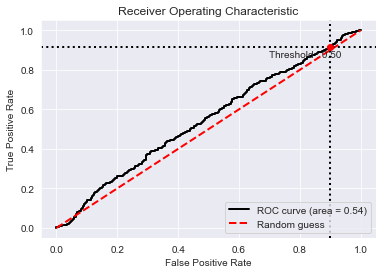

In [333]:
from plot_metric.functions import BinaryClassification
logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

bc.plot_roc_curve()
plt.show()

$\textbf{Neural Networks Classifier}$

In [336]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

In [337]:
# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())

# ROC Curve
fpr1, tpr1, threshold1 = roc_curve(y_test.values, clf1.predict_proba(X_test)[:,1])
fpr2, tpr2, threshold2 = roc_curve(y_test.values, clf2.predict_proba(X_test)[:,1])
fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

Iteration 1, loss = 1.02226955
Iteration 2, loss = 0.97556568
Iteration 3, loss = 0.93729030
Iteration 4, loss = 0.90642802
Iteration 5, loss = 0.88205924
Iteration 6, loss = 0.86225647
Iteration 7, loss = 0.84591923
Iteration 8, loss = 0.83145678
Iteration 9, loss = 0.81927428
Iteration 10, loss = 0.80868522
Iteration 11, loss = 0.79937574
Iteration 12, loss = 0.79126751
Iteration 13, loss = 0.78395363
Iteration 14, loss = 0.77722168
Iteration 15, loss = 0.77136843
Iteration 16, loss = 0.76604742
Iteration 17, loss = 0.76123562
Iteration 18, loss = 0.75660390
Iteration 19, loss = 0.75222894
Iteration 20, loss = 0.74856258
Iteration 21, loss = 0.74493553
Iteration 22, loss = 0.74191490
Iteration 23, loss = 0.73896489
Iteration 24, loss = 0.73627840
Iteration 25, loss = 0.73369877
Iteration 26, loss = 0.73119637
Iteration 27, loss = 0.72896609
Iteration 28, loss = 0.72671604
Iteration 29, loss = 0.72477450
Iteration 30, loss = 0.72297762
Iteration 31, loss = 0.72121362
Iteration 32, los

0.5869467028003613
0.5799457994579946
0.5815266485998193
0.5785907859078591
0.681345980126468
0.6205962059620597


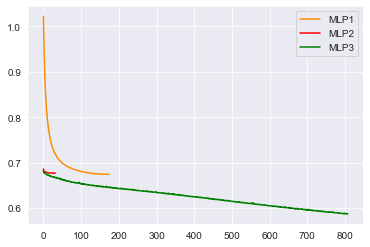

In [338]:
print(clf1.score(X_train, y_train.values.ravel()))
print(clf1.score(X_test, y_test.values.ravel()))
print(clf2.score(X_train, y_train.values.ravel()))
print(clf2.score(X_test, y_test.values.ravel()))
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(clf1.loss_curve_,color="darkorange",label="MLP1")
plt.plot(clf2.loss_curve_,color="red",label="MLP2")
plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

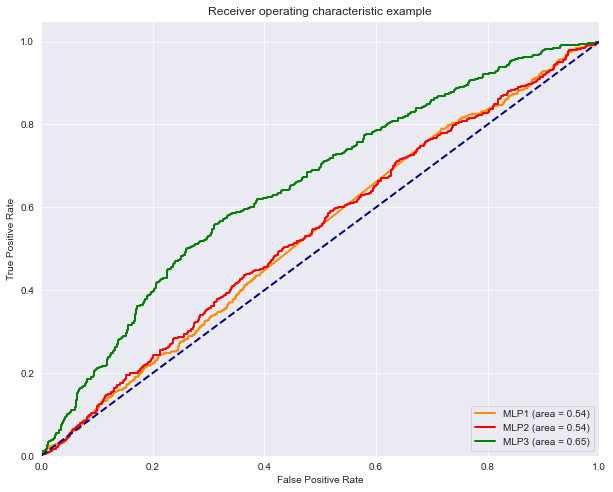

In [339]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    label="MLP1 (area = %0.2f)" % roc_auc1,
)
plt.plot(
    fpr2,
    tpr2,
    color="red",
    lw=lw,
    label="MLP2 (area = %0.2f)" % roc_auc2,
)
plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [341]:

print_score(clf3, X_train, y_train, X_test, y_test, train=True)
print_score(clf3, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 68.13%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.665260     0.688955  0.681346     0.677108      0.678890
recall        0.502924     0.813113  0.681346     0.658019      0.681346
f1-score      0.572813     0.745903  0.681346     0.659358      0.672375
support    1881.000000  2547.000000  0.681346  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[ 946  935]
 [ 476 2071]]

_______________________________________________
ROV CURVE SCORE 
 0.6580187217159508

Test Result:
Accuracy Score: 62.06%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.559140    0.648863  0.620596     0.604001      0.611478
recall       0.422764    0.761905  0.620596     0.592334      0.620596
f1-score     0.481481    

In [342]:
GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.573622        0.007657  RandomForestClassifier
1              0.591010        0.011322      AdaBoostClassifier
2              0.600047        0.011766       Gradient Boosting
3              0.554195        0.021967  DecisionTreeClassifier


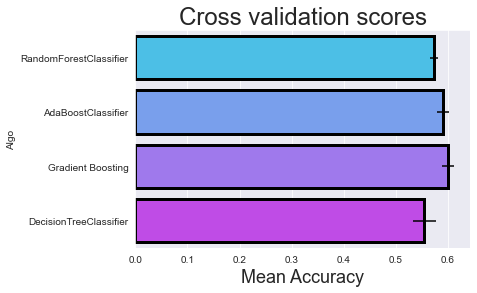

<Figure size 1080x504 with 0 Axes>

In [343]:
kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

In [344]:
from sklearn.linear_model import LogisticRegression

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 58.11%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.825000     0.578851  0.581075     0.701926      0.683415
recall        0.017544     0.997252  0.581075     0.507398      0.581075
f1-score      0.034357     0.732516  0.581075     0.383437      0.435940
support    1881.000000  2547.000000  0.581075  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[  33 1848]
 [   7 2540]]

_______________________________________________
ROV CURVE SCORE 
 0.5073977641394417

Test Result:
Accuracy Score: 58.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy    macro avg  weighted avg
precision    0.50000    0.583902  0.583333     0.541951      0.548943
recall       0.00813    0.994193  0.583333     0.501161      0.583333
f1-score     0.01600    0.73

$\textbf{We are going to add for each step the exogenous features}$

* Uplift Account 1
* Uplift Account 2
* Uplift Account 3

In [362]:
Uplift_accounts = [features[6],features[7],features[8]]

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[6],features[7],features[8],features[13],features[14],features[15],"Date"], axis=1)
x.head()



RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [353]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [354]:
X_train.head()

mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-10-24 21:00:00                 119.3700                  6.231135   
2022-02-20 12:00:00                  90.0000                  4.495077   
2021-11-02 18:00:00                 126.9975                  7.087896   
2021-12-03 19:00:00                 146.2125                  9.143689   
2022-04-02 03:00:00                  88.3275                  5.535335   

                        RES    Load  Mandatory Hydro  Total FRR  
2021-10-24 21:00:00  2530.0  5015.5             45.0     1724.0  
2022-02-20 12:00:00  2525.0  5883.5             63.0     1621.0  
2021-11-02 18:00:00  1560.0  6651.5            433.5     1449.0  
2021-12-03 19:00:00  2590.0  6912.5            420.5     1804.0  
2022-04-02 03:00:00  2535.0  4069.0              0.0     1016.0

In [355]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []
num_columns = X_train.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [356]:
####### I am going to use only the Neural Classifier with tanh activation function


clf3.fit(X_train, y_train.values.ravel())

fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

0.8335591689250226
0.6747967479674797


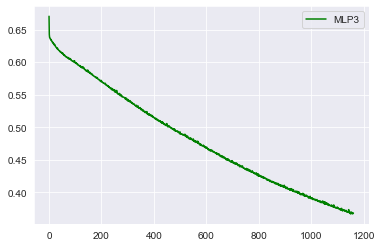

In [357]:
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc3 = auc(fpr3, tpr3)


plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

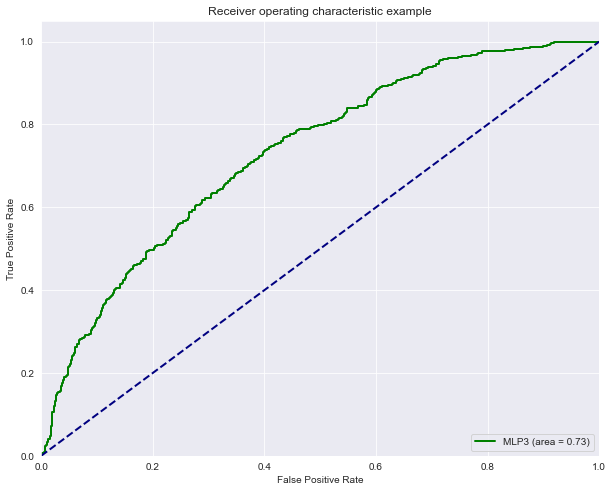

In [358]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

$\textbf{Multi Class Classification}$

Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


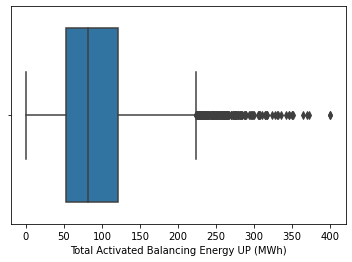

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


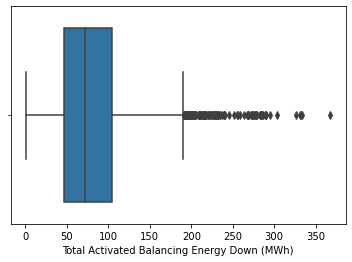

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


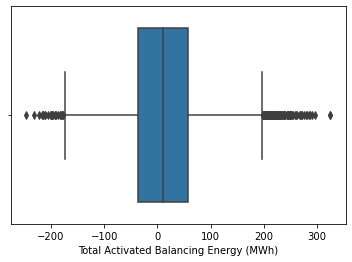

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


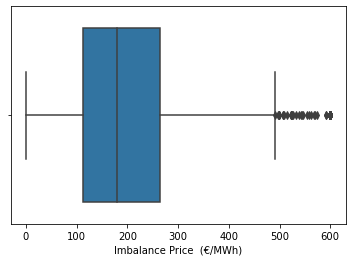

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


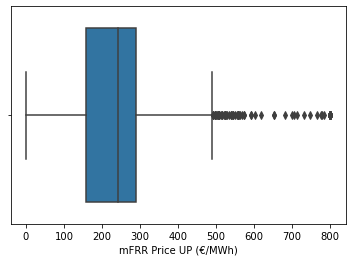

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


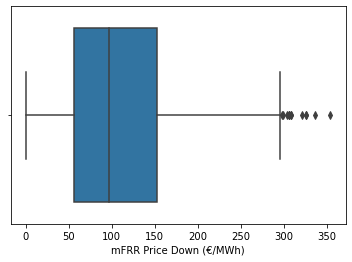

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


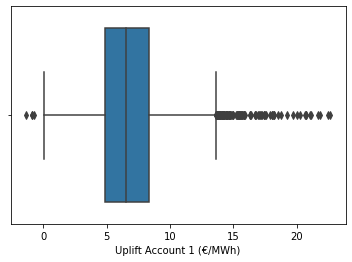

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


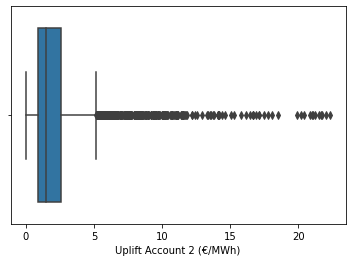

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


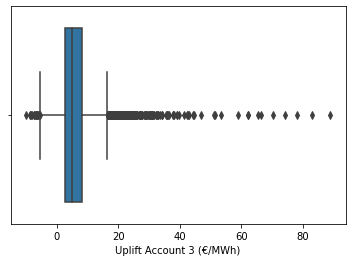

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


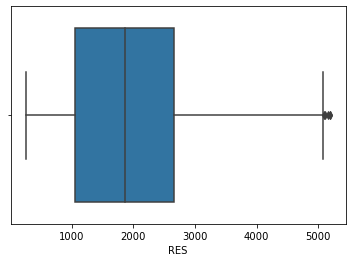

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


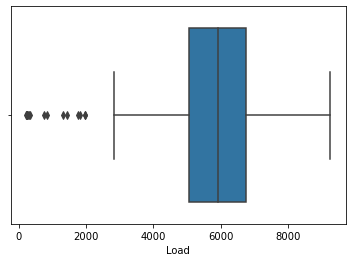

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


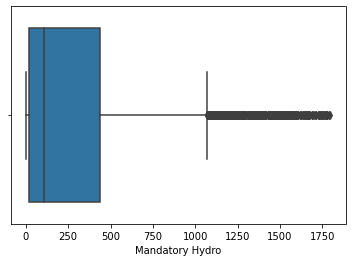

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


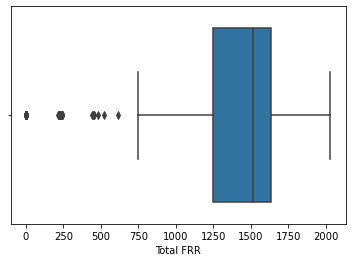

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


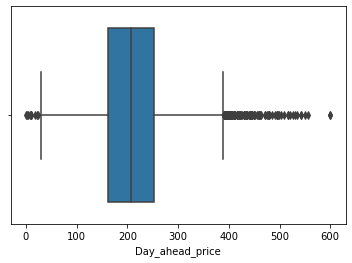

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


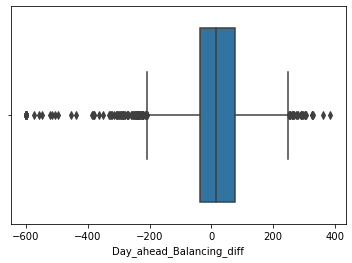

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 125 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns
Boxplot, IQR, qutliner for Diff_direction


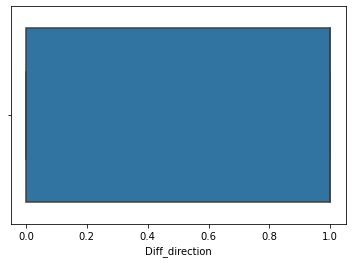

IQR For Diff_direction Column :  1.0
There are 0 outliers out of 5904 data points.


In [325]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [324]:
combined_dataframes[features[14]].loc[combined_dataframes[features[14]] <= -600 ] = -600

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [388]:
min(combined_dataframes[features[14]])

-600.0

In [ ]:
combined_dataframes['Label'] = pd.cut(x=combined_dataframes[features[14]],
                     bins=[min(combined_dataframes[features[14]]),-10,78,max(combined_dataframes[features[14]])],
                     labels=['0','1','2'],include_lowest=True)


In [ ]:
combined_dataframes.head(50)
df_info(combined_dataframes)

In [ ]:
features = combined_dataframes.columns

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[7],features[8],features[13],features[14],features[15],features[17],"Date"], axis=1)
x.head()


y = combined_dataframes['Label']
y.value_counts()

In [ ]:
x.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.countplot(data=combined_dataframes, x='Label')
plt.title('Classes (Negative and Positive Difference)')
plt.xlabel("Difference Direction")
plt.show()

In [396]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [397]:
###### Statistics for 
df_info(X_train)

type  \
Uplift Account 1 (€/MWh)  float64   
RES                       float64   
Load                      float64   
Mandatory Hydro           float64   
Total FRR                 float64   

                                                                     Sample  \
Uplift Account 1 (€/MWh)  [6.1615839225, 3.1928560625, 6.912970425, 6.11...   
RES                                 [2875.0, 3925.0, 675.0, 1985.0, 1790.0]   
Load                               [7564.0, 7208.5, 5389.5, 6276.0, 6486.0]   
Mandatory Hydro                          [1076.0, 37.0, 105.5, 348.5, 62.0]   
Total FRR                             [1324.0, 1646.0, 0.0, 1526.0, 1536.0]   

                          % of NaN  Corr_with_y  Duplicates  Amount Uniques  \
Uplift Account 1 (€/MWh)         0          NaN           0            4428   
RES                              0          NaN           0             832   
Load                             0          NaN           0            3437   
Mandatory Hydro                  0          NaN           0            1338   
Total FRR                        0          NaN           0             466   

                          Uniques  Outliers  
Uplift Account 1 (€/MWh)  Several         0  
RES                       Several         0  
Load                      Several         0  
Mandatory Hydro           Several         0  
Total FRR                 Several         0

In [398]:
y_train.value_counts()

0    1671
1    1649
2    1108
Name: Label, dtype: int64

In [399]:
y_test.value_counts()

0    551
1    550
2    375
Name: Label, dtype: int64

In [400]:
num_columns = X_train.columns

In [401]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []


ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [414]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        #print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        #print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

In [415]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

#from plot_metric.functions import BinaryClassification
#logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
#bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

#bc.plot_roc_curve()
#plt.show()

Train Result:
Accuracy Score: 46.48%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.487536     0.449545     0.366197   0.46477     0.434426   
recall        0.608618     0.599757     0.046931   0.46477     0.418435   
f1-score      0.541389     0.513900     0.083200   0.46477     0.379496   
support    1671.000000  1649.000000  1108.000000   0.46477  4428.000000   

           weighted avg  
precision      0.443026  
recall         0.464770  
f1-score       0.416501  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[1017  609   45]
 [ 615  989   45]
 [ 454  602   52]]

_______________________________________________
Test Result:
Accuracy Score: 48.24%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.507983    0.458167  

$\textbf{Support Vector Machine}$

In [417]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
#Y_pred_label = list(encoder.inverse_transform(Y_pred))

In [ ]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test  , y_test))

svm_model.score

$\textbf{Boosted Decision Trees Classification}$

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold

GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)


In [ ]:

gradient_boost_roc = gradient_fit.predict_proba(X=X_test)
bc = BinaryClassification(y_test, gradient_boost_roc[:,1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

from sklearn.linear_model import LogisticRegression

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)